<img src="https://certificate.tpq.io/taim_logo.png" width="350px" align="right">

# Artificial Intelligence in Finance

## Dense Neural Networks

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## The Data

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.head()

HIGH     LOW    OPEN   CLOSE
Date                                               
2019-10-01 00:00:00  1.0899  1.0897  1.0897  1.0899
2019-10-01 00:01:00  1.0899  1.0896  1.0899  1.0898
2019-10-01 00:02:00  1.0898  1.0896  1.0898  1.0896
2019-10-01 00:03:00  1.0898  1.0896  1.0897  1.0898
2019-10-01 00:04:00  1.0898  1.0896  1.0897  1.0898

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

In [10]:
data = data.resample('1h', label='right').last().ffill()
data.tail()

EUR_USD
Date                        
2019-12-31 21:00:00   1.1216
2019-12-31 22:00:00   1.1215
2019-12-31 23:00:00   1.1208
2020-01-01 00:00:00   1.1211
2020-01-01 01:00:00   1.1211

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 02:00:00 to 2020-01-01 01:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


In [12]:
data.plot(figsize=(10, 6));

## Baseline Prediction

In [13]:
lags = 5

In [14]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [15]:
data, cols = add_lags(data, symbol, lags)

In [19]:
data

EUR_USD           r     sma     min     max         mom  \
Date                                                                           
2019-10-02 03:00:00   1.0937 -9.1429e-05  1.0916  1.0879  1.0938  2.2911e-04   
2019-10-02 04:00:00   1.0937  0.0000e+00  1.0918  1.0885  1.0938  2.6586e-04   
2019-10-02 05:00:00   1.0936 -9.1437e-05  1.0921  1.0886  1.0938  2.3372e-04   
2019-10-02 06:00:00   1.0933 -2.7436e-04  1.0923  1.0886  1.0938  1.8786e-04   
2019-10-02 07:00:00   1.0935  1.8292e-04  1.0925  1.0886  1.0938  1.9700e-04   
...                      ...         ...     ...     ...     ...         ...   
2019-12-31 21:00:00   1.1216 -5.3481e-04  1.1216  1.1201  1.1238  4.9061e-05   
2019-12-31 22:00:00   1.1215 -8.9162e-05  1.1216  1.1201  1.1238  3.5679e-05   
2019-12-31 23:00:00   1.1208 -6.2436e-04  1.1216  1.1201  1.1238 -1.7841e-05   
2020-01-01 00:00:00   1.1211  2.6763e-04  1.1216  1.1201  1.1238  8.9206e-06   
2020-01-01 01:00:00   1.1211  0.0000e+00  1.1216  1.1201  1.1238  1.7843e-05   

                        vol  d  EUR_USD_lag_1  EUR_USD_lag_2  ...   mom_lag_1  \
Date                                                          ...               
2019-10-02 03:00:00  0.0008  0         1.0938         1.0932  ...  2.2449e-04   
2019-10-02 04:00:00  0.0008  0         1.0937         1.0938  ...  2.2911e-04   
2019-10-02 05:00:00  0.0008  0         1.0937         1.0937  ...  2.6586e-04   
2019-10-02 06:00:00  0.0008  0         1.0936         1.0937  ...  2.3372e-04   
2019-10-02 07:00:00  0.0008  1         1.0933         1.0936  ...  1.8786e-04   
...                     ... ..            ...            ...  ...         ...   
2019-12-31 21:00:00  0.0006  0         1.1222         1.1226  ...  9.8118e-05   
2019-12-31 22:00:00  0.0006  0         1.1216         1.1222  ...  4.9061e-05   
2019-12-31 23:00:00  0.0007  0         1.1215         1.1216  ...  3.5679e-05   
2020-01-01 00:00:00  0.0007  1         1.1208         1.1215  ... -1.7841e-05   
2020-01-01 01:00:00  0.0007  0         1.1211         1.1208  ...  8.9206e-06   

                      mom_lag_2   mom_lag_3   mom_lag_4   mom_lag_5  \
Date                                                                  
2019-10-02 03:00:00  2.0165e-04  2.0626e-04  1.8789e-04  1.6035e-04   
2019-10-02 04:00:00  2.2449e-04  2.0165e-04  2.0626e-04  1.8789e-04   
2019-10-02 05:00:00  2.2911e-04  2.2449e-04  2.0165e-04  2.0626e-04   
2019-10-02 06:00:00  2.6586e-04  2.2911e-04  2.2449e-04  2.0165e-04   
2019-10-02 07:00:00  2.3372e-04  2.6586e-04  2.2911e-04  2.2449e-04   
...                         ...         ...         ...         ...   
2019-12-31 21:00:00  1.0255e-04  1.2935e-04  1.0258e-04  7.1371e-05   
2019-12-31 22:00:00  9.8118e-05  1.0255e-04  1.2935e-04  1.0258e-04   
2019-12-31 23:00:00  4.9061e-05  9.8118e-05  1.0255e-04  1.2935e-04   
2020-01-01 00:00:00  3.5679e-05  4.9061e-05  9.8118e-05  1.0255e-04   
2020-01-01 01:00:00 -1.7841e-05  3.5679e-05  4.9061e-05  9.8118e-05   

                     vol_lag_1  vol_lag_2  vol_lag_3  vol_lag_4  vol_lag_5  
Date                                                                        
2019-10-02 03:00:00     0.0008     0.0008     0.0008     0.0008     0.0008  
2019-10-02 04:00:00     0.0008     0.0008     0.0008     0.0008     0.0008  
2019-10-02 05:00:00     0.0008     0.0008     0.0008     0.0008     0.0008  
2019-10-02 06:00:00     0.0008     0.0008     0.0008     0.0008     0.0008  
2019-10-02 07:00:00     0.0008     0.0008     0.0008     0.0008     0.0008  
...                        ...        ...        ...        ...        ...  
2019-12-31 21:00:00     0.0006     0.0006     0.0006     0.0007     0.0007  
2019-12-31 22:00:00     0.0006     0.0006     0.0006     0.0006     0.0007  
2019-12-31 23:00:00     0.0006     0.0006     0.0006     0.0006     0.0006  
2020-01-01 00:00:00     0.0007     0.0006     0.0006     0.0006     0.0006  
2020-01-01 01:00:00     0.0007     0.0007     0.0006     0.0006     0.0006  



In [16]:
len(data)

2183

In [17]:
# data.iloc[:10, :14].round(4)

In [18]:
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [21]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [22]:
class_weight = cw(data)

In [23]:
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [24]:
class_weight[0] * c[0]

1091.5

In [25]:
class_weight[1] * c[1]

1091.5

In [28]:
import random
import logging
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
tf.get_logger().setLevel(logging.ERROR)

In [29]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [30]:
optimizer = Adam(lr=0.001)

C:\Users\MIG\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [32]:
set_seeds()
model = create_model(hl=1, hu=128)

In [33]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

Wall time: 7.13 s


In [34]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 0s 2ms/step - loss: 0.5945 - accuracy: 0.6015


[0.5945016741752625, 0.6014658808708191]

In [35]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

In [36]:
data['p'].value_counts()

1    1410
0     773
Name: p, dtype: int64

In [37]:
split = int(len(data) * 0.8)

In [38]:
train = data.iloc[:split].copy()

In [39]:
test = data.iloc[split:].copy()

In [40]:
set_seeds()
model = create_model(hl=1, hu=128)

In [41]:
%%time 
h = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 6.57 s


In [42]:
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.5934


[0.6096417903900146, 0.5933562517166138]

In [43]:
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.6133


[0.5931045413017273, 0.6132723093032837]

In [44]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

In [45]:
test['p'].value_counts()

1    284
0    153
Name: p, dtype: int64

In [46]:
res = pd.DataFrame(h.history)

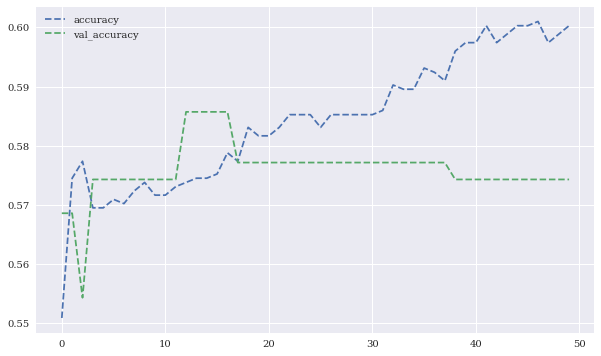

In [47]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Normalization

In [48]:
mu, std = train.mean(), train.std()

In [49]:
train_ = (train - mu) / std

In [50]:
# train_.std().round(3)

In [51]:
set_seeds()
model = create_model(hl=2, hu=128)

In [52]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 6.67 s


In [53]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.9170


[0.4276737868785858, 0.9169530272483826]

In [54]:
test_ = (test - mu) / std

In [55]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 1.4907 - accuracy: 0.6705


[1.4907170534133911, 0.6704805493354797]

In [56]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [57]:
test['p'].value_counts()

0    310
1    127
Name: p, dtype: int64

In [58]:
res = pd.DataFrame(h.history)

In [60]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

# We can see that trtaining accuracy increases to impressive levels but validation accuracy stagnates around 65-67%
# That is even pretty high

## Dropout 

In [61]:
from keras.layers import Dropout

In [62]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                 optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [63]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [64]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

Wall time: 8.18 s


In [65]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.7732


[0.4451799690723419, 0.7731958627700806]

In [66]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.6430


[0.5794059634208679, 0.6430205702781677]

In [67]:
res = pd.DataFrame(h.history)

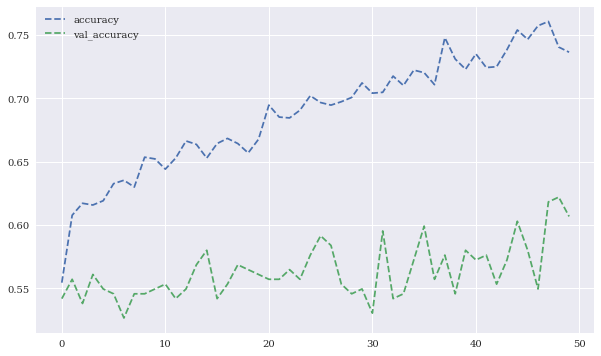

In [68]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Regularization 

In [69]:
from keras.regularizers import l1, l2

In [70]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, 
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [71]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [72]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 7.05 s


In [73]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.3618 - accuracy: 0.9032


[0.36178624629974365, 0.9032073020935059]

In [76]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.8782 - accuracy: 0.6590


[0.8782317638397217, 0.6590389013290405]

In [77]:
res = pd.DataFrame(h.history)

In [78]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [79]:
set_seeds()
h = model = create_model(hl=2, hu=128,
                     dropout=True, rate=0.3,
                     regularize=True, reg=l2(0.001),
                    )

In [80]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 8.95 s


In [81]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7789


[0.4671570360660553, 0.7789232730865479]

In [82]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.6568


[0.6518753170967102, 0.6567505598068237]

In [83]:
res = pd.DataFrame(h.history)

In [84]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [85]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

0.08685526371002195

## Bagging

In [86]:
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [87]:
len(cols)

40

In [88]:
max_features = 0.75

In [89]:
set_seeds()
base_estimator = KerasClassifier(build_fn=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=True, regularize=False,
                        input_dim=int(len(cols) * max_features))

<ipython-input-89-3b017fc0cf1a>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  base_estimator = KerasClassifier(build_fn=create_model,


In [90]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [91]:
%time model_bag.fit(train_[cols], train['d'])

Wall time: 34.7 s


BaggingClassifier(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022687702490>,
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [92]:
model_bag.score(train_[cols], train['d'])

0.7623138602520045

In [96]:
model_bag.score(test_[cols], test['d'])
#High values due to class imbalance as seen from below

0.6636155606407322

In [94]:
test['p'] = model_bag.predict(test_[cols])

In [95]:
test['p'].value_counts()

0    381
1     56
Name: p, dtype: int64

## Optimizers

In [97]:
import time

In [98]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [99]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 7.4238 | in-sample=0.6077 | out-of-sample=0.6499
rmsprop    | time[s]: 7.3161 | in-sample=0.7176 | out-of-sample=0.6293
adagrad    | time[s]: 7.1989 | in-sample=0.5630 | out-of-sample=0.6293
adadelta   | time[s]: 7.6251 | in-sample=0.6438 | out-of-sample=0.6545
adam       | time[s]: 7.4706 | in-sample=0.6982 | out-of-sample=0.6453
adamax     | time[s]: 6.9589 | in-sample=0.6357 | out-of-sample=0.6613
nadam      | time[s]: 7.7990 | in-sample=0.7423 | out-of-sample=0.6430
Wall time: 53.9 s


In [100]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [101]:
test['p'].value_counts()

0    242
1    195
Name: p, dtype: int64

In [102]:
accuracy_score(test['p'], test['d'])

0.6430205949656751

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>